## Prelude

Setting up the data from the previous notebook

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("data/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="data")
    return pd.read_csv(Path("data/housing/housing.csv"))

housing = load_housing_data()

housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

# Data Cleaning and Preparation

## Splitting data into train and test

As discussed in the book, we want to ensure that the data we use to train the model has the same "shape" as the test data.  The amount of effort you put into this critically depends on domain knowledge and the data analysis you performed in the first stage (EDA). From the book:

<div class="warning" style='background-color:#E9D8FD; color: #69337A; border: solid #805AD5 4px; border-radius: 4px; padding:0.7em; width:90%'>

“Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely (back in Figure 2-8): most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:”

Excerpt From: Aurélien Géron. “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition.” Apple Books. 
</div>

In [2]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

The above code helps us to characterize a continuous range in an equitable manner, but we still need to make sure our test and train data have the same rough distribution over categories. We can do this by passing a `stratify` parameter (which specifies which features to stratify upon) to the `train_test_split` method.

In [3]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [4]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Handling NAs

In the book 3 options are listed to handle the NaN values:

```python
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

For each option, we'll create a copy of `housing` and work on that copy to avoid breaking `housing`. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [5]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house,income_cat
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND,5.923503,NaN,2.774945,3
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN,5.193548,NaN,4.354839,3
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN,5.245136,NaN,4.272374,3
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN,6.367713,NaN,2.542601,4
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN,6.918033,NaN,2.049180,5


In [6]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house,income_cat


In [7]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house,income_cat
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND,5.923503,NaN,2.774945,3
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN,5.193548,NaN,4.354839,3
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN,5.245136,NaN,4.272374,3
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN,6.367713,NaN,2.542601,4
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN,6.918033,NaN,2.049180,5


## Imputation

Alternatively, we can impute the data!  "Imputation" means filling the data in with assumptions based on other values in the dataset. Here, we just imputing with the median value.  There are many additional approaches here, though.

In [8]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house,income_cat
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND,5.923503,NaN,2.774945,3
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN,5.193548,NaN,4.354839,3
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN,5.245136,NaN,4.272374,3
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN,6.367713,NaN,2.542601,4
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN,6.918033,NaN,2.049180,5


Instead of doing this by hand, we can use SKLearn's imputation methods.  We'll cover this more later.

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [10]:
housing_num = housing.select_dtypes(include=[np.number])

In [11]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [12]:
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12500000e+03,
        4.34000000e+02,  1.16700000e+03,  4.08000000e+02,  3.53850000e+00,
        5.23557310e+00,  2.03105786e-01,  2.82231619e+00])

Check that this is the same as manually computing the median of each attribute:

In [13]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12500000e+03,
        4.34000000e+02,  1.16700000e+03,  4.08000000e+02,  3.53850000e+00,
        5.23557310e+00,  2.03105786e-01,  2.82231619e+00])

Note that imputers in SciKit learn follow the "Transformer" API, which is used to transform data prior to modeling.

In [14]:
X = imputer.transform(housing_num)

In [15]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_house', 'bedrooms_ratio', 'people_per_house'],
      dtype=object)

In [16]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [17]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,5.923503,0.203106,2.774945
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,5.193548,0.203106,4.354839
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,5.245136,0.203106,4.272374
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,6.367713,0.203106,2.542601
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,6.918033,0.203106,2.049180


In [18]:
imputer.strategy

'median'

In [19]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [20]:
housing_tr.loc[null_rows_idx].head()  # not shown in the book

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,5.923503,0.203106,2.774945
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,5.193548,0.203106,4.354839
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,5.245136,0.203106,4.272374
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,6.367713,0.203106,2.542601
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,6.918033,0.203106,2.049180


## Removing Outliers

Another important step in data pre-processing is the removal of outliers.  There are several ways to do this - here, we use SciKit Learn's Isolation forest.  However, it's equally reasonable just to examine distributions and set thresholds on your data.

In [21]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [22]:
outlier_pred

array([-1,  1,  1, ...,  1,  1, -1])

If you wanted to drop outliers, you would run the following code:

In [23]:
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

## Handling Text and Categorical Attributes

The SciKit learn API doesn't really handle categorical attributes, which means we have to transform them into a numeric representation.  This is called _encoding_.  Here, we'll preprocess the categorical input feature, `ocean_proximity`:

In [24]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


We'll use an ordinal encoder here, which simply replaces each categorical entry with a number corresponding to it's sort order (alphabetic, if not otherwise specified).

In [25]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [26]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [27]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

As we will discuss, ordinal encoding is not always a great idea, because it introduces a distance attribute where this may not be intended.  For instance, consider a categorical column containing fruits like "apple", "banana", and "cantaloupe".  These would become encoded as 0,1, and 2 respectively.  An ML model might interpret this to mean that apples and bananas are closer together than apples and cantaloupes.  For this reason, we usually encode categorical attributes with a one-hot encoder, we transforms each unique categorical value into a single binary attribute. This can be done in either pandas or sklearn - we will generally prefer the latter, even though the version in pandas has a somewhat simpler API.  We will discuss the merits of both later on.

In [28]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

The preceding code will transform training data in one step.  We can then use this transformer to transform new, unseen data (our test set).

## Feature Scaling

When fitting a model, it's often important to make sure all values are roughly of the same order of magnitude.  The `MinMaxScaler` does this by scaling numbers to the range 0-1.

In [29]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [66]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,3.725256,0.277371,1.631399
...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,4.277247,0.266875,1.793499
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,5.535714,0.201019,2.667293
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,5.157895,0.197704,3.702632
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,4.511933,0.230891,2.058473


A standard scaler is another approach to scaling values, also known as the "z-score" of a variable.  This centers the data at 0 and divides by the standard deviation.

In [30]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

The above approaches work well for data that is normally distributed, but with non-normal (e.g., heavy-tailed) distributions, data is often "squashed" to one end of the range.  This makes it hard for some kind of learners.  To address this, we might instead discretize data such that data becomes more evenly distributed across it's entire range.  For example:

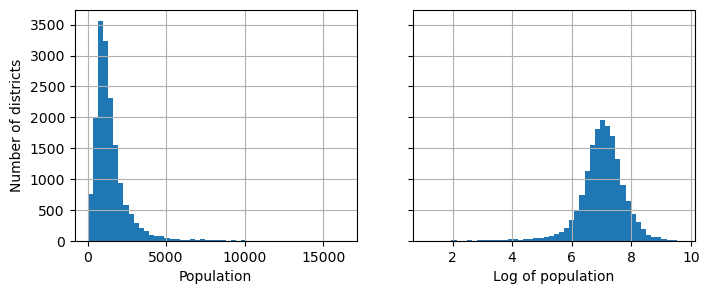

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

If we instead replace the data with it's percentile categories, we get a much more even spread.

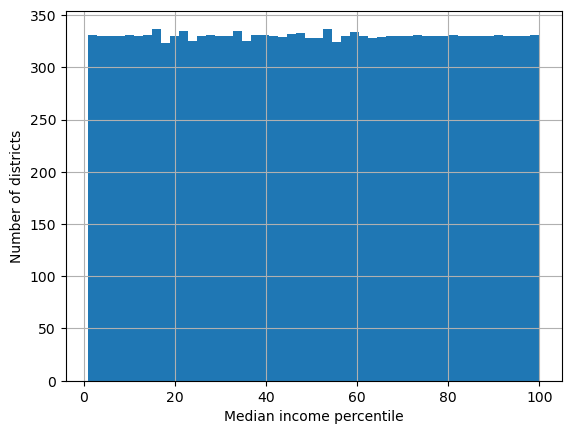

In [32]:
# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

Note that we usually want to scale the output variable as well, especially in the case of regression problems.  However, that leads to a problem - how do we interpret the prediction of the model?  Luckily the SciKit transformer API provides methods for performing an inverse transform to get data back using the original range. 

In [33]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [34]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

The `TranformedTargetRegressor` takes care of this for us.

In [35]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [36]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Advanced:  The Transformer API

As with the "Estimator API" (which provides methods like `fit()`, `predict()`, and `fit_predict()`, Scikit-learn provides a "Transformer API" - really an extension of the Estimator API - which is used to transform data as part of an analysis pipeline. Transformers in Scikit-Learn are a type of class designed to preprocess data before it is fed into a machine learning model. The primary role of Transformers is to transform raw data into a format that is more suitable for modeling.  This includes:

- **Scaling or Normalizing Data**: Adjusting the scale of features so that they have consistent ranges, which is important for many ML algorithms.
- **Handling Missing Values**: Filling or removing missing values in the dataset.
- **Encoding Categorical Variables**: Converting categorical variables into numeric formats that can be used in ML models.
- **Feature Extraction**: Generating new features from existing data (e.g., extracting features from text data).
- **Dimensionality Reduction**: Reducing the number of features in a dataset while retaining most of the important information.

#### Basic Use of Transformers
Transformers in Scikit-Learn typically follow a simple, standardized process:
1. **Fitting**: The transformer is fitted to the data, which means it learns any parameters it needs from the data (e.g., mean and standard deviation for scaling).
2. **Transforming**: The transformer applies the transformation to the data, modifying it as required.
3. **Fitting and Transforming**: Some transformers can perform both steps simultaneously using a `fit_transform` method, which is more efficient.

#### Common Transformers in Scikit-Learn
Some of the widely used transformers in Scikit-Learn include:
- **StandardScaler**: For standardizing features by removing the mean and scaling to unit variance.
- **MinMaxScaler**: Scales features to a given range, typically between zero and one.
- **SimpleImputer**: Provides basic strategies for imputing missing values.
- **OneHotEncoder**: Converts categorical variables into a one-hot numeric array.

Transformers can also be combined in pipeline, which is covered in more depth below.

#### Custom Transformers

Scikit-learn also provides tools that simplify the construction of custom transformers.  For example, the `FunctionTransfomer` allows you to build a transformer that applies a custom function.

In [37]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

Here, we apply an `rbf_kernel` to smooth out noisy data.  See the book for more.

In [38]:
from sklearn.metrics.pairwise import rbf_kernel

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [39]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [40]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [41]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [42]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

You can even build a more sophisticated transformer, with learnable parameters, by extended the `TransformerMixin` class.  The following class illustrates how to do this to replicate the `StandardScaler` functionality (for illustrative purposes).

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

Here, we construct a more complex transformer that learns a clustering in the `fit` method, and then compares new data to the identified cluster centers.

In [44]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

This can be used to generate Figure 2-19 in the book.

In [45]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [46]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

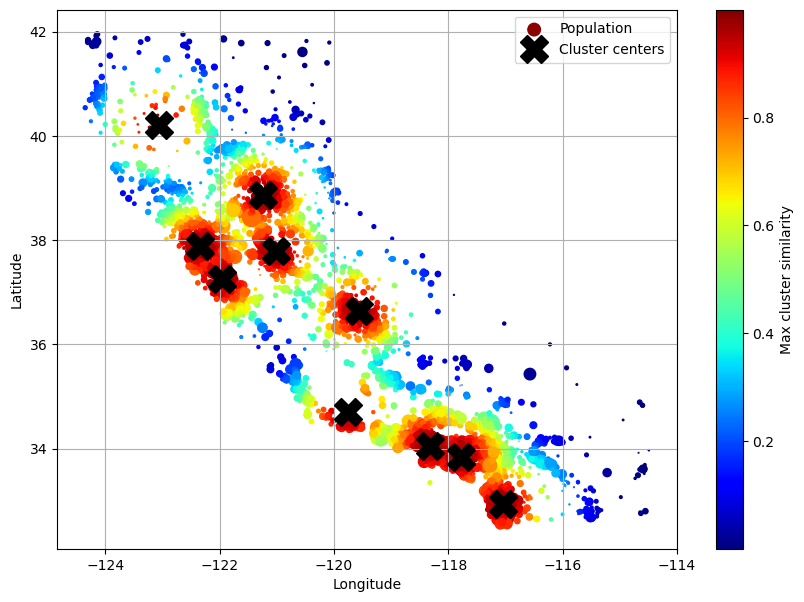

In [47]:

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

## Advanced: Using Pipelines

In Scikit-Learn, a Pipeline is a tool that sequentially applies a list of transforms and a final estimator. Essentially, it bundles together preprocessing steps and model training so that they can be executed as a single process. This makes the workflow much more manageable, replicable, and less prone to errors.

#### Purpose of Pipelines
- **Simplification of Workflow**: Pipelines streamline the process of transforming data and applying a model, reducing the complexity of handling multiple preprocessing steps.
- **Avoiding Data Leakage**: By ensuring that preprocessing steps are applied within each fold of cross-validation, pipelines prevent data leakage, leading to more accurate model evaluation.
- **Reproducibility and Deployment**: Pipelines make the model building process more reproducible and simplify the deployment of models.

### Using Pipelines with Transformers

#### Combining Transformers and Estimators
In Scikit-Learn, a pipeline can consist of a series of transformers followed by a final estimator (such as a machine learning model). Here's how they work together:

1. **Sequential Processing**: Each step in a pipeline is executed in sequence. A transformer processes the data and passes it to the next step in the pipeline.
2. **Automatic Fitting and Transforming**: For each transformer, the pipeline automatically calls `fit` and `transform` methods during the training phase. For the final estimator, it calls the `fit` method.
3. **Single Interface for the Entire Process**: The entire sequence of preprocessing and modeling steps can be executed using the pipeline's `fit` and `predict` methods.

#### Example of a Pipeline with Transformers
Consider a pipeline that includes data scaling, dimensionality reduction, and a classification model:
- **Step 1: Scaling Data** - Using a transformer like `StandardScaler` to standardize the features.
- **Step 2: Dimensionality Reduction** - Applying a transformer like `PCA` (Principal Component Analysis) to reduce the number of dimensions.
- **Step 3: Model Training** - Using an estimator, such as a logistic regression classifier, to train on the transformed data.

#### Benefits of Using Pipelines with Transformers
- **Efficiency**: Streamlines the process of data transformation and model training.
- **Error Reduction**: Minimizes the risk of mistakes, such as applying transformations in the wrong order or

using training data parameters to transform the test data.
- **Ease of Experimentation**: Allows for easy experimentation with different combinations of transformers and models.
- **Code Maintainability**: Pipelines help in organizing code better, making it more readable and maintainable.

### Example using a Pipeline with Transformers

Now let's build a pipeline to preprocess the numerical attributes:

In [48]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [49]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [50]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [51]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94, -0.87,
         2.15, -0.33],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17,  0.02,
        -0.57, -0.25]])

In [52]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [53]:
df_housing_num_prepared.head(2) 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,-0.866027,2.153743,-0.330204
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,0.024550,-0.569651,-0.253616


In [54]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [55]:
num_pipeline[1]

StandardScaler()

In [56]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [57]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [58]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

Note that the preceding pipeline handles numeric features, but how do we deal with categorical features? We make another pipeline!  Scikit-learn provides a utility class, `ColumnTransformer` that allows us to bundles different pipelines together and apply them to different columns depending on selection criteria you establish.  In the following, we bundle our two pipelines together to handle the full dataset.

In [59]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [60]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [61]:
housing_prepared = preprocessing.fit_transform(housing)

In [62]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-1__rooms_per_house,pipeline-1__bedrooms_ratio,pipeline-1__people_per_house,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,-0.866027,2.153743,-0.330204,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,0.024550,-0.569651,-0.253616,1.0,0.0,0.0,0.0,0.0


In [63]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [64]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 28)

In [65]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__rooms_per_house',
       'remainder__bedrooms_ratio', 'remainder__people_per_house',
       'remainder__income_cat'], dtype=object)